In [1]:
import json
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
from simulation import minimal_model as mm
from surrogate import neural_network

from sampling.grid import Grid
from sampling.random import Random
from sampling.lhs import LatinHyperCube, OrtogonalLatinHyperCube
from sampling.greedy_farpoint import GREEDYFP

from visualise import stream, surface

2024-06-10 18:15:45.147630: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 18:15:45.970583: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [32]:
def plot_results_seaborn(results):
    # Create a new figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12), sharex=True)

    # Plot the first lineplot on the first axis
    sns.lineplot(data=results, x='n', y='mse_run', hue='method', marker='o', ax=ax1)
    ax1.set_ylabel('Mean Squared Error (Run)')
    ax1.set_title('MSE (Run) vs Number of Samples for Different Methods')
    ax1.set_yscale('log')
    ax1.grid(True)

    # Plot the second lineplot on the second axis
    sns.lineplot(data=results, x='n', y='mse_method', hue='method', marker='o', ax=ax2)
    ax2.set_xlabel('Number of Samples (n)')
    ax2.set_ylabel('Mean Squared Error (Test)')
    ax2.set_title('MSE (Test) vs Number of Samples for Different Methods')
    ax2.set_yscale('log')
    ax2.grid(True)

    plt.tight_layout()

    # Show the plot
    plt.show()

In [4]:
def get_primes(n):
    out = list()
    sieve = [True] * (n+1)
    for p in range(2, n+1):
        if (sieve[p] and sieve[p]%2==1):
            out.append(p)
            for i in range(p, n+1, p):
                sieve[i] = False
    return out

In [5]:
# All sampling methods instances you want to test.
sampling_methods = [Random, Grid, LatinHyperCube, OrtogonalLatinHyperCube, GREEDYFP]

In [6]:
g = 1.78
B_lim, D_lim = 2.9, 0.4
bounds = [(0, D_lim), (0, B_lim)]

# Experiments

In [34]:
def experiment(sampling_methods, n_requested_samples, ranges, g, hyper_parameters, folds = 10):
    random_state = 12345

    results = pd.DataFrame(columns=['method', 'n', 'mse_run', 'mse_method', 'mae_run', 'mae_method', 'hp', 'uid', 'epochs', 'fold'])

    req_sqrt = [int(np.sqrt(n)) for n in n_requested_samples]
    primes = [get_primes(sq)[-1] for sq in req_sqrt]
    n_samples = [prime**2 for prime in primes]

    n_eval = 10**4
    D_true, B_true = Random.sample_stack(ranges, n_eval)
    true_dB_dt, true_dD_dt = mm.step(B_true, D_true, g, warm_up=0)
    # The same across all current experiments
    X_test = np.column_stack((B_true.flatten(), D_true.flatten(), np.repeat(g, (n_eval))))
    y_test = np.column_stack((true_dB_dt.flatten(), true_dD_dt.flatten()))

    for method in sampling_methods:
        method_name = str(method.__name__)
        for i, n in enumerate(n_samples):
            refresh_max = int(n/10) if int(n/10) > 5 else 5

            # TODO: A If applicable 10 refreshes per sample size
    	    # Run the methods N times and retrain OR
            for fold in range(folds):
                D_points, B_points = method.sample_stack(ranges, n, random_state=random_state, refresh_count=refresh_max, scale=2)
                train_dB_dt, train_dD_dt = mm.step(B_points, D_points, g)
                X = np.column_stack([B_points.flatten(), D_points.flatten(), np.repeat(g, (n))])
                y = np.column_stack([train_dB_dt.flatten(), train_dD_dt.flatten()])
                print(method_name, n, X.shape)

                # TODO: B Only retrain with the same inital data.
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=random_state)
                NN = neural_network.NeuralNetwork(hyper_parameters)
                NN.train(X_train, y_train, X_val, y_val, verbose=False)

                y_true_pred = NN.predict(X_test)
                y_val_pred = NN.predict(X_val)

                new_row = pd.DataFrame([{
                    'method': method_name,
                    'n': n,
                    'mse_run': mean_squared_error(y_test, y_true_pred), # Unseen large random dataset.
                    'mse_method': mean_squared_error(y_val, y_val_pred), # Unseen already validated on set from method dataset.
                    'mae_run': mean_absolute_error(y_test, y_true_pred), # Unseen large random dataset.
                    'mae_method': mean_absolute_error(y_val, y_val_pred), # Unseen already validated on set from method dataset.
                    'hp': hyper_parameters,
                    'uid': NN.uid,
                    'epochs': len(NN.history.history['loss']),
                    'fold': fold
                }])
                results = pd.concat([results, new_row], ignore_index=True)

    return results

In [35]:
# All sampling methods instances you want to test.
sampling_methods = [Random, Grid, LatinHyperCube, OrtogonalLatinHyperCube, GREEDYFP]

# Approximations of N total samples. Should be cubes of a prime. Will be translated if it is not.
n_requested_samples = [25, 50, 121, 200, 529, 1849]

hp = {
    'units': [256, 256, 256, 128, 64],
    'act_fun': 'relu',
    'learning_rate': 0.005,
    'batch_size': 32,
    'l2_reg': 1e-4,
    'n_epochs': 400}

results = experiment(sampling_methods, n_requested_samples, bounds, g, hp, 7)

Random 25 (25, 3)
NN training time: 0.285 minutes.
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Random 25 (25, 3)


/tmp/ipykernel_2163668/1134964791.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


NN training time: 0.256 minutes.
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Random 25 (25, 3)
NN training time: 0.253 minutes.
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Random 25 (25, 3)
NN training time: 0.25 minutes.
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Random 25 (25, 3)
NN training time: 0.246 minutes.
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Random 25 (25, 3)
NN training time: 0.246 minutes.
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Random 25 (25, 3)
NN training time: 0.275 minutes.
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Random 49 (49, 3)
NN training time: 0.27 minutes.
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Random 49 (49, 3)
NN training time: 0.164 minutes.
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━

In [36]:
results.head(20)

,method,n,mse_run,mse_method,mae_run,mae_method,hp,uid,epochs,fold
0,Random,25,0.013908,0.010331,0.059995,0.057827,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240610_193457,400,0
1,Random,25,0.006636,0.003329,0.034471,0.028990,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240610_193515,400,1
2,Random,25,0.006890,0.002845,0.033744,0.027390,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240610_193531,386,2
3,Random,25,0.007008,0.003201,0.034261,0.029173,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240610_193546,400,3
4,Random,25,0.007110,0.003579,0.035953,0.033108,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240610_193602,400,4
5,Random,25,0.007272,0.004432,0.040889,0.037016,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240610_193617,400,5
6,Random,25,0.022124,0.019404,0.076741,0.080564,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240610_193632,400,6
7,Random,49,0.022326,0.037137,0.089879,0.129035,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240610_193650,400,0
8,Random,49,0.028156,0.041780,0.104905,0.139581,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240610_193706,231,1
9,Random,49,0.006419,0.019105,0.039615,0.071558,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240610_193717,400,2


In [37]:
# prev = "20240610_114941"
# df1 = pd.read_csv(f"data/experiments/{prev}.csv", index_col='Unnamed: 0')

# prev = "20240608_164804"
# df2 = pd.read_csv(f"data/experiments/{prev}.csv", index_col='Unnamed: 0')

# df_double = pd.concat([df1, df2], ignore_index=True)

In [38]:
# df_gp = df_double.groupby(["method", 'n'])[['mse_run', 'mse_method', 'mae_run', 'mae_method']].mean()
# plot_results_seaborn(df_gp.reset_index())

In [39]:
# plot_results_seaborn(df1)
# plot_results_seaborn(df2)
# plot_results_seaborn(df_double)

In [43]:
df = results.copy(deep=True)
df['mae_diff'] = np.abs(df['mae_method'] - df['mae_run'])
df['mse_diff'] = np.abs(df['mse_method'] - df['mse_run'])

In [41]:
# hist = neural_network.load_history('20240610_114541')
# neural_network.plot_history(hist)

# uids = results[results['method'] == 'OrtogonalLatinHyperCube\'>']['uid'].values
# for uid in uids:
#     hist = neural_network.load_history(uid)
#     neural_network.plot_history(hist)

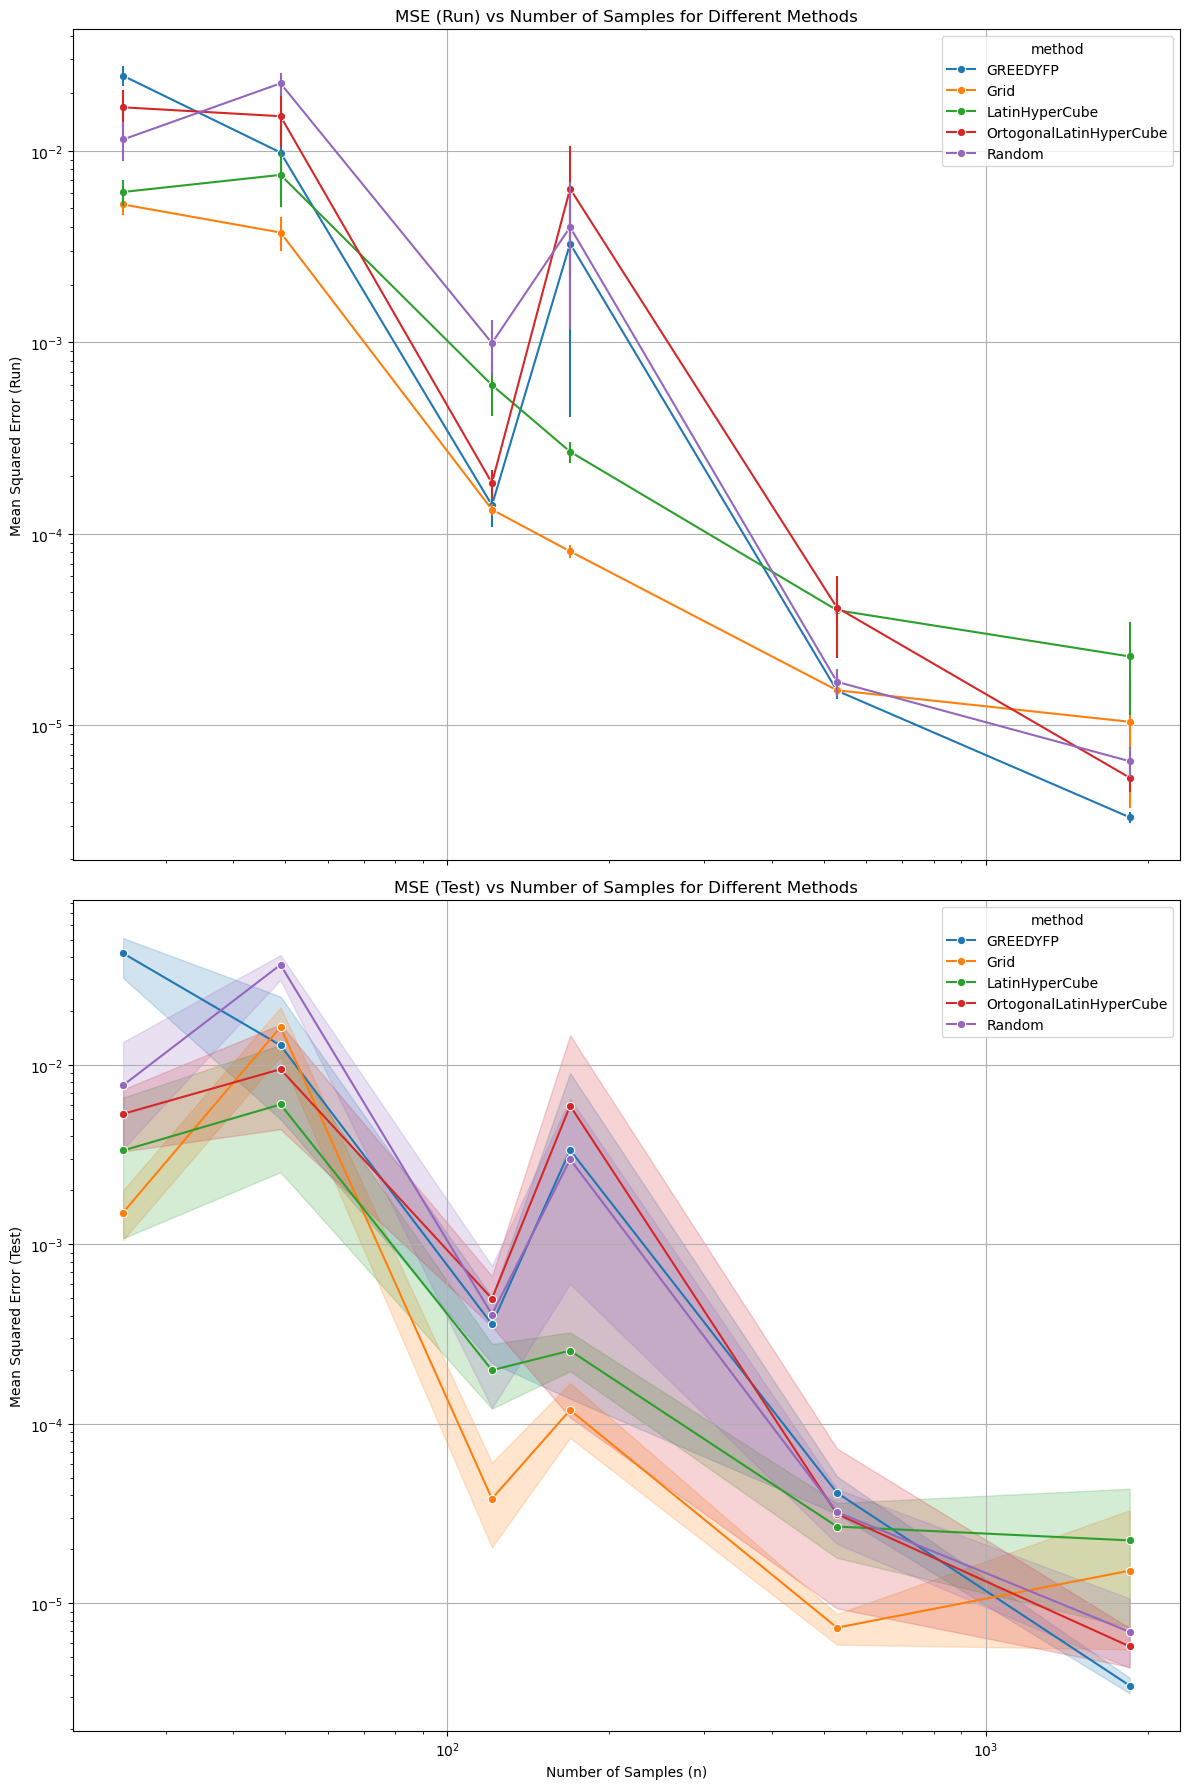

In [74]:
def plot_results_seaborn(results):
    # Create a new figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,18), sharex=True)

    # Plot the first lineplot on the first axis
    sns.lineplot(data=results, x='n', y='mse_run', hue='method', marker='o', err_style="bars", errorbar=("se"), ax=ax1)
    ax1.set_ylabel('Mean Squared Error (Run)')
    ax1.set_title('MSE (Run) vs Number of Samples for Different Methods')
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.grid(True)

    # Plot the second lineplot on the second axis
    sns.lineplot(data=results, x='n', y='mse_method', hue='method', marker='o', ax=ax2)
    # sns.lineplot(data=results, x='n', y='mse_method', hue='method', marker='o', err_style="bars", errorbar=("se"), ax=ax2)
    ax2.set_xlabel('Number of Samples (n)')
    ax2.set_ylabel('Mean Squared Error (Test)')
    ax2.set_title('MSE (Test) vs Number of Samples for Different Methods')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.grid(True)

    plt.tight_layout()

    # Show the plot
    plt.show()

plot_results_seaborn(df_10)

In [29]:
df.to_csv(f"data/experiments/{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")